# Description

Perform asset optimization 


Methods : 
* Equally weighted
* 
* 
* 


**NE PAS OUBLIER**
* FAIRE LA RACINE CARREE SUR LA VOLATILITE POUR CALCULER LE RISQUE
* Implémentation rebalancement
* implémentation tracking error (voir https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/tracking-error/)
* astuce de modelisation gurobipy
    * https://support.gurobi.com/hc/en-us/community/posts/360074491212-Divisor-must-be-a-constant
    * http://yetanothermathprogrammingconsultant.blogspot.com/2016/08/portfolio-optimization-maximize-sharpe.html



# Setup

In [1]:
%matplotlib notebook
%load_ext autoreload

## Imports


In [6]:



# os related
from pathlib import Path
import os 

# data related
import pandas as pd
# import missingno as msno
import datetime as dt
import numpy as np
import pickle
import json

# optimization related
# from gurobipy import (Model, GRB, quicksum, multidict, tuplelist)

# visual related
import matplotlib.pyplot as plt
import seaborn as sns

# time related



from fonctions import *

## Paths

In [8]:
# MUST BE IN CODE FOLDER TO WORK !
PROJECT_PATH = Path(os.getcwd()).parent

RAW_DATA = PROJECT_PATH / "RAW_DATA" 
PROC_DATA = PROJECT_PATH / "PROC_DATA"

# RAW FILES
CSV_FILE = RAW_DATA / "Individual_stock_data_csv.csv"
XLSX_FILE = RAW_DATA / "Individual_stock_data.xlsx"

# PROC FILES
PROC_STOCK = PROC_DATA / "proc_stock.csv"
PROC_CARBON = PROC_DATA / "proc_carbon.csv"

STOCK_2000 = PROC_DATA / "stock_2000.csv"


STOCK_WORK = PROC_DATA / "stock_work.csv"
STOCK2USE = PROC_DATA / "stock2use.csv"
DIC2USE = PROC_DATA / "dic2use.json"


OUT_RENDEMENT = PROC_DATA / "rendement_v1"

OUT_DF_CSV = PROC_DATA / "optimize_assets.csv"
OUT_DF_CSV_CARBON = PROC_DATA / "optimize_assets_carbon_penalty.csv"

DIC_CARBON_INTENSITY_JSON = PROC_DATA / "dic_intensity.json"

## Utils

In [9]:
with open(DIC_CARBON_INTENSITY_JSON) as jsonFile:
    dic_intensity = json.load(jsonFile)

## HYPERPARAMETERS

In [10]:
USE_CARBON_PENALTY = True

In [11]:
EW_INTENSITY = sum(dic_intensity.values()) * 1/50



# Notebook

## Loading data

<IPython.core.display.Javascript object>


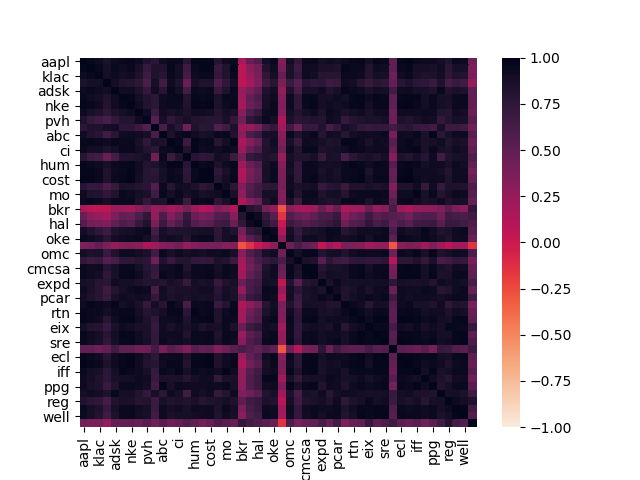

In [12]:


df = read_file(STOCK2USE)

carbon_df = read_file(PROC_CARBON, index="company")

## EW

# mean, std = equally_weighted(df) # correct std function in fonctions.py 

weeks = 12
nb_period = len(df)//12

# df_period = 
# compute_weights(df_period, method)
# apply weights
# compute(return and risk)
# compute


sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="rocket_r")

## GMV

In [84]:

cov = df.cov().to_numpy()
def gmv(cov, nb_weights=50, intensity_list=None, penalty=1.5):
    """Function that computes weights for global minimum volatility
    Parameters:
    cov(matrix):covariance of data
    nb_weights(int):number of weights to optimize
    intensity_list : list of intensity of stock to optimize
    penalty : to apply in objective
    Returns:
    weights(list)"""
    
    model = Model()
    model.modelSense = GRB.MINIMIZE

    # Définir poids
    w = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)

    arr = np.array(w.select("*"))
    vecw_col = np.reshape(arr, (len(arr), 1)) # vecteur colonne des poids

    # Contraintes
    model.addConstr(w.sum() == 1)
        
    obj = np.dot(vecw_col.T,np.dot(cov, vecw_col))[0][0]
    if intensity_list is not None:
        obj += np.dot(vecw_col.T, intensity_list)[0] * penalty
    model.setObjective(obj)

    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()
    
    opt_w =  [w[i].x for i in range(len(w))]
    
    return opt_w



## Max Decor

In [88]:


# cor = df.corr().to_numpy()
# plt.figure()
# sns.heatmap(cor)

def max_decor(corr, nb_weights=50, intensity_list=None, penalty=1.5):
    model = Model()

    model.modelSense = GRB.MINIMIZE

    # Définir poids
    w = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)
    arr = np.array(w.select("*"))
    vecw_col = np.reshape(arr, (len(arr), 1)) # vecteur colonne des poids
    # Contraintes
    model.addConstr(w.sum() == 1)
    
    obj = np.dot(vecw_col.T, np.dot(corr, vecw_col))[0][0]    
    if intensity_list is not None:
        obj += np.dot(vecw_col.T, intensity_list)[0] * penalty
    model.setObjective(obj)    
    
    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()
    
    opt_w =  [w[i].x for i in range(len(w))]
    return opt_w

In [ ]:
# opt_w = [w[i].x for i in range(len(w))]
# max_weight = max(opt_w)
# max_idx = opt_w.index(max_weight)
# df.columns[max_idx]

# plt.figure()
# df["ipg"].plot()

# carbon_df.loc["ipg"]

# df.corr()[["ipg"]].describe().quantile()

# for weight in sorted(opt_w, reverse=True):
#     idx = opt_w.index(weight)
#     print(df.columns[idx])

# df.corr()[["omc"]].describe()

# carbon_df.loc["omc"]

## Max div

In [90]:


def max_div(cov, nb_weights=50, intensity_list=None, penalty=1.5):
    
    
    model = Model()
    model.modelSense = GRB.MINIMIZE
    y = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS)
    arr = np.array(y.select("*"))
    vecy_col = np.reshape(arr, (len(arr), 1)) 

    strd = np.sqrt(np.diag(cov))
    
    yp = np.dot(vecy_col.T,np.reshape(strd,(len(strd),1)))

    port_variance = np.dot(vecy_col.T,np.dot(cov, vecy_col))[0][0]

    model.addConstr(yp[0][0] == 1)
    obj = port_variance

    if intensity_list is not None:
        obj += np.dot(vecy_col.T, intensity_list)[0] * penalty
    model.setObjective(obj)  
    
    model.setObjective(obj)
    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()
    
    opt_w = [y[i].x /y.sum().getValue() for i in range(len(y))]
    
    return opt_w

# xopt = [y[i].x /y.sum().getValue() for i in range(len(y))]

## MSR

In [91]:


def msr(mu, cov, nb_weights=50, intensity_list=None, penalty=1.5):
    
    model = Model()
    model.modelSense = GRB.MINIMIZE

    y = model.addVars(nb_weights, vtype=GRB.CONTINUOUS)
    arr = np.array(y.select("*"))
    vecy_col = np.reshape(arr, (len(arr), 1))

    yp = np.dot(vecy_col.T,np.reshape(mu,(len(mu),1)))
    port_variance = np.dot(vecy_col.T,np.dot(cov, vecy_col))[0][0]

    model.addConstr(yp[0][0] == 1)
    obj = port_variance
    
    if intensity_list is not None:
        obj += np.dot(vecy_col.T, intensity_list)[0] * penalty
    model.setObjective(obj)

    model.setObjective(obj)

    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()

    opt_w = [y[i].x / y.sum().getValue() for i in range(len(y))]
    
    return opt_w

## Rebalancement


### preparation dataset de poids

In [93]:

# de la semaine 0 à la semaine 103
nb_period = (len(df) - 104) // 12


pf_names = ['ew', 'gmv', 'maxdecor', 'maxdiv', 'msr']

dic_weight = {
    pf:pd.DataFrame(index=range(nb_period), columns=df.columns)
for pf in pf_names
}

### Calcul

In [101]:
# de la semaine 0 à la semaine 103
nb_period = (len(df) - 104) // 12
PENALTY = 1
INTENSITY=list(dic_intensity.values())

# output dataframe
cols= ["ew", "gmv", "maxdecor", "maxdiv", "msr"]
out_df = pd.DataFrame(index=range((len(df) - 104)), columns=cols)

for i in range((nb_period)):
    print(i)
    
    # retrieve data
    temp_df = df.iloc[i*12:104+i*12] # 2 dernieres annees glissantes sur 3 mois
    # print(temp_df.index[0],"->",temp_df.index[-1], len(temp_df))
    mu = temp_df.pct_change().mean() # Vérifier s'il faut enlever les Nans
    cov = temp_df.cov()
    std = temp_df.std()
    corr = temp_df.corr()
    
    # Train
    w_gmv = gmv(cov, intensity_list=INTENSITY, penalty=PENALTY)
    dic_weight["gmv"].iloc[i] = w_gmv
    
    w_mdecor = max_decor(corr, intensity_list=INTENSITY, penalty=PENALTY)
    dic_weight["maxdecor"].iloc[i] = w_mdecor
    
    w_mdiv = max_div(cov, intensity_list=INTENSITY, penalty=PENALTY)
    dic_weight["maxdiv"].iloc[i] = w_mdiv
    
    w_msr = msr(mu.values, cov, intensity_list=INTENSITY, penalty=PENALTY)
    dic_weight["msr"].iloc[i] = w_msr
    
    dic_weight["ew"].iloc[i] = [(1/len(df.columns))] * len(df.columns)
    
    # Test
    test_period = df.iloc[-1+104+i*12:104+(i+1)*12]  # test data sur les 3 mois suivants   
    test_mu = test_period.pct_change()[1:]
     
    out_df["gmv"].iloc[i*12:(i+1)*12] = (test_mu * w_gmv).sum(axis=1) * 100
    out_df["maxdecor"].iloc[i*12:(i+1)*12] = (test_mu * w_mdecor).sum(axis=1) * 100
    out_df["maxdiv"].iloc[i*12:(i+1)*12] = (test_mu * w_mdiv).sum(axis=1) * 100
    out_df["msr"].iloc[i*12:(i+1)*12] = (test_mu * w_msr).sum(axis=1) * 100
    out_df["ew"].iloc[i*12:(i+1)*12] = (test_mu.sum(axis=1) / len(test_period.columns)) * 100

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77


In [102]:



out_df.dropna(inplace=True)

if USE_CARBON_PENALTY:
    out_df.to_csv(OUT_DF_CSV_CARBON)
else:
    out_df.to_csv(OUT_DF_CSV)


# Calcul des metrics

- Rendement annualisé
- Ratio de sharp
- Tracking error
- Excess return 
- Rendement du S&P 500
- Calcul de l'ENC




Sur les 1 an
* Rendement portefeuille (annualisé) 
* Risque du portefeuille (annualisé)
* tracking error 
* mu / sigma
* mup - mub (ecés par rapport au benchmark)
* (mup - mub) / tracking error
* EnC / 50 (50%)



In [105]:
if USE_CARBON_PENALTY:
    for pf in dic_weight.keys():
        dic_weight[pf].to_csv(PROC_DATA / f"carbon_weight_{pf}.csv")
else:
    for pf in dic_weight.keys():
        dic_weight[pf].to_csv(PROC_DATA / f"weight_{pf}.csv")